# PC 9 : Résolution numérique d'EDP paraboliques

**<big> Préparation avant la PC :</big>**
**Les question 1 des exercices 1 et 2 sont à préparer** avant la séance de PC du 09/11.

**<big><font color=black><span style="background-color:deepskyblue">Bonus</span></font> après la PC :</big>** 

**Les exercices 1 et 2 contiennent des questions d'implémentation (en bleu) qui peuvent être rendues avant le 13/11 à 20h pour obtenir un <font color=black><span style="background-color:deepskyblue">bonus</span></font> sur la note finale**.

In [1]:
# Ce package permet de travailler efficacement avec des tableaux
import numpy as np

# Ce package permet de travailler avec des matrices creuses
import scipy.sparse as sparse
# On pourra utiliser la décomposition LU pour les matrices creuses
from scipy.sparse.linalg import splu, spsolve
# On pourra utiliser la fonction norme
from numpy.linalg import norm

# Ce package permet de faire des sorties graphiques
from matplotlib import pyplot as plt

## Exercice 1 : Équation de la chaleur

>Soient $\nu>0$ un coefficient de diffusion, un intervalle $\Omega=]0,L[$, $L>0$, et $u^0\in C^0(\Omega)$ une donnée initiale. On considère l'équation de la chaleur :
>
>$$ \left\{ \begin{aligned}
      &\displaystyle\frac{\partial u}{\partial t}(t,x) - \nu\frac{\partial^2 u}{\partial x^2}(t,x) = 0, \quad &\forall (t,x) \in\mathbb{R}_+^*\times\Omega, \\ 
      &\frac{\partial u}{\partial x}(t,0) = 0 = \frac{\partial u}{\partial x}(t,L) \quad &\forall t\in\mathbb{R}_+^*, \\ 
      &u(x,0) = u^0(x), \quad &\forall x\in\Omega.
    \end{aligned}
    \right. \qquad{} (1) $$
>
>  On admettra les résultats suivants concernant l'EDP (1) et on essaiera de démontrer leurs équivalents discrets :
>- L'équation de la chaleur (1) admet une unique solution.
>- **Principe du maximum :**
>
>$$  \forall~0\leq s<t<\infty,\ \forall x\in\Omega, \quad{} \min_{y\in\Omega} u(s,y) \leq u(t,x) \leq \max_{y\in\Omega} u(s,y).  $$
>
>- **Conservation de la masse :**
>
>  $$ \forall~0\leq t<\infty, \quad{} \int_\Omega u(t,x) dx = \int_\Omega u^0(x) dx.  $$
>
>- **Décroissance de l'énergie :**
>
>  $$ \forall~0\leq s<t<\infty, \quad{} \int_\Omega \vert u(t,x)\vert^2 dx \leq \int_\Omega \vert u(s,x)\vert^2 dx. $$
>
> Afin d'étudier numériquement l'équation de la chaleur (1), on va considérer différentes méthodes numériques et étudier leurs propriétés.
>- Pour la discrétisation en temps, on fixe un temps final $T>0$, puis on considère 
>
> $$ N\in\mathbb{N}^*, \qquad{} \Delta t = \frac{T}{N} \quad{} \text{et} \quad{} t^n = n\Delta t,\ n = 0, \dots, N. $$
>
>- Pour la discrétisation en espace, on considère
>
> $$ J\in\mathbb{N}^*, \qquad{} \Delta x = \frac{L}{J} \quad{} \text{et}\quad{} x_j = j\Delta x,\ j = -1, \dots, J+1. $$
>
>- On note 
>
> $$ U^0_j = u^0(x_j),\quad{} j = 0, \dots, J, $$
>
>  et on va chercher à construire de manière itérative une suite $U^n = \left(U^n_j\right)_{0\leq j \leq J}$ telle que $U^n_j$ approche $u(t^n,x_j)$.
>
>Pour les questions d'implémentation, dans cet exercice on prendra 
>
> $$  \nu = 1,\quad{} L=10,\quad{} J=100, \quad{} u^0(x) = 2 - \cos \frac{2\pi x}{L},  $$
>
>et différentes valeurs de $T$ et de $\Delta t$ données plus loin.

### Question 1 : Solution théorique

Vérifier que la solution de (1) avec la condition initiale donnée ci-dessus est

$$ u(t,x) = 2 - e^{-\nu\frac{4\pi^2}{L^2}t}\cos\left(\frac{2\pi x}{L}\right). $$

<div class="alert alert-block alert-info">
    On calcule
    $$\begin{align}
    \begin{cases}
        \frac{\partial}{\partial t} u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = \left( \frac{\nu 4\pi^2}{L^2} - \nu\frac{4\pi^2}{L^2} \right)e^{-\nu\frac{4\pi^2}{L^2}t}\cos\left(\frac{2\pi x}{L}\right) = 0\\
        \frac{\partial}{\partial x}u(t,0) = 0 = \frac{\partial}{\partial x}u(t,L) \\
        u(0, x) = 2 - \cos\left(\frac{2\pi x}{L}\right) = u^0(x)
    \end{cases}
    \end{align}$$
    d'où $u(t,x)$ est solution.
</div>

### Question 2 : Schéma "différences finies" explicite en temps

>On considère le schéma donné par
>
> $$ \frac{U^{n+1}_j - U^n_j}{\Delta t} - \nu \frac{U^n_{j-1}-2U^n_j+U^n_{j+1}}{(\Delta x)^2} = 0 \qquad{} \forall~n\geq 0,\quad{} \forall~0 \leq j\leq J.\qquad{} (2) $$
>
>Pour $j=0$ (resp. $j=J$), ce schéma fait apparaitre $U^n_{-1}$ (resp. $U^n_{J+1}$). Ces deux quantités seront determinées par les conditions bords. En discrétisant les conditions de Neumann de manière décentrée ou centrée, on obtient
>
> $$ \frac{U_0^n - U^n_{-1}}{\Delta x} = 0 \quad{}\text{et}\quad{} \frac{U^n_{J+1} - U^n_{J}}{\Delta x} = 0, \qquad{}(3a) $$
>
>ou
>
> $$ \frac{U_1^n - U^n_{-1}}{2\Delta x} = 0 \quad{}\text{et}\quad{} \frac{U^n_{J+1} - U^n_{J-1}}{2\Delta x} = 0. \qquad{} (3b) $$
>
>Les avantages et inconvénients de chacunes de ces deux discrétisations seront étudiés à travers les différentes questions.

$1$. **Réécriture matricielle du schéma :**

Donner les matrices $A^{expl}_1$ et $A^{expl}_2$ de taille $(J+1) \times (J+1)$ permettant d'écrire le schéma (2) sous la forme $U^{n+1}=A^{expl}_1 U^n$ pour la convention (3a) et $U^{n+1}=A^{expl}_2 U^n$ pour la convention (3b). 

*Indication : On pourra faire apparaitre le nombre sans dimension $\alpha = \frac{\nu \Delta t}{\Delta x^2}$.*

<div class="alert alert-block alert-info">
    On a la récurrence
    $$\begin{align}
    U_j^{n+1} &= U_j^{n} + \nu\frac{\Delta t}{\Delta x^2}\left(U_{j+1}^n - 2U_j^n + U_{j-1}^n\right)\\
    &= \alpha U_{j+1}^n + (1 - 2\alpha)U_j^n + \alpha U_{j-1}^n
    \end{align}$$
    Avec les condition aux bords, on a
    $$A_1^{expl} = \begin{pmatrix}
1-\alpha & \alpha & 0 & \cdots & 0 & 0 & 0 \\
\alpha & 1-2\alpha & \alpha & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & ... & \alpha & 1-2\alpha & \alpha \\
0 & 0 & 0 & ... & 0 & \alpha & 1-\alpha
\end{pmatrix}$$
    et
    $$A_2^{expl} = \begin{pmatrix}
1-2\alpha & 2\alpha & 0 & \cdots & 0 & 0 & 0 \\
\alpha & 1-2\alpha & \alpha & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & ... & \alpha & 1-2\alpha & \alpha \\
0 & 0 & 0 & ... & 0 & 2\alpha & 1-2\alpha
\end{pmatrix}$$
</div>

$2$. **Propriétés numériques :**

$a$. **Consistance** 

>On définit l'erreur locale de troncature $\varepsilon^n=\left(\varepsilon_j^n\right)_{0\leq j\leq J}$ du schéma (2) par 
>
> $$ \varepsilon_j^n = \frac{u(t^{n+1},x_j) - u(t^n,x_j)}{\Delta t} - \nu \frac{u(t^n,x_{j-1}) - 2u(t^n,x_j) + u(t^n,x_{j+1})}{(\Delta x)^2}, $$
>
>pour tout $1\le j \le J-1$ et
>
>$$\begin{aligned}
  \varepsilon_0^n   &= \frac{u(t^{n+1},x_0   ) - u(t^n,x_0   )}{\Delta t} - \nu \frac{-2u(t^n,x_0)+2u(t^n,x_{1})}{(\Delta x)^2}, \\
  \varepsilon_{J}^n &= \frac{u(t^{n+1},x_{J}) - u(t^n,x_{J})}{\Delta t} - \nu \frac{2u(t^n,x_{J-1})-2u(t^n,x_{J})}{(\Delta x)^2},
\end{aligned}$$ 
>  
>lorsqu'on considère les conditions de bord (3b). 
>On dit que le schéma est d'ordre $p$ en temps et $q$ en espace s'il existe $C\in\mathbb{R}^+$ telle que $\max\limits_{j,n} |\varepsilon_j^n| \le C (\Delta t^p + \Delta x^q)$.

Montrer que le schéma (2) avec les conditions de bord (3b) est consistant. 

$b$. Donner son ordre. *On pourra supposer la solution aussi régulière que nécessaire.* 
  
$c$. **Stabilité en norme $\ell_{\Delta x}^2$** 

>On dit que le schéma (2) muni des conditions de bord (3a) ou  (3b) est stable pour la norme $\| . \|$ s'il existe $C\in\mathbb{R}^+$ indépendante de $\Delta x$ et de $\Delta t$ (mais pouvant dépendre de $T$) telle que, pour toute donnée initiale $U^0$,
>
> $$ \|U^n\| \le C(T) \|U^0\| \quad{}\forall~n\ge 0. $$
>
>On définit la norme $\ell^2_{\Delta x}$ de $U^n$ par
>
> $$\begin{aligned} \left\Vert U^n \right\Vert_{\ell^2_{\Delta x}} := \sqrt{\Delta x \sum_{j=0}^{J+1} \left(U^n_j\right)^2} = \sqrt{\Delta x} \left\Vert U^n \right\Vert_{2}.\end{aligned}$$
>
>**Remarque :** si $U^n_j$ approche bien $u(t^n,x_j)$, alors cette norme approche la norme $L^2$ de la fonction $x\mapsto u(t^n,x)$, quand $\Delta x\to 0$.

Donner une condition nécessaire sur $\alpha$ pour que le schéma (2-3a) soit stable en norme $\ell^2_{\Delta x}$.

*Indication : on pourra étudier le spectre de $A_1^{expl}$ à l'aide du théorème de Gerschgorin .*

On supposera dans la suite que le schéma (2-3b) est également stable pour cette norme.

$d$. **Convergence en norme $\ell_{\Delta x}^2$** 

>Un schéma est dit convergent en norme $\| . \|$ si 
>
>$$ \lim\limits_{\Delta t, \Delta x \rightarrow 0}\sup\limits_{t^n \le T} \|e^n\| \rightarrow 0 $$
>
>où $e^n$ est le vecteur d'erreur donnée par $e_j^n = U_j^n - u(t^n,x_j)$, $j=0,\ldots,J$.

Montrer la convergence en norme $\ell_{\Delta x}^2$ du schéma (2-3b) sous la condition stabilité trouvée à la question précédente.

*Indication : de manière analogue à ce qu'on a fait pour les EDO, on pourra réécire $\left(u(t^{n+1},x_j)\right)_{0\leq j \leq J}$ en fonction de $\left(u(t^n,x_j)\right)_{0\leq j \leq J}$, $A^{expl}$, et $\varepsilon^n$.* 

<div class="alert alert-block alert-info">
    Par Taylor, on a
    $$ \frac{u(t_{n+1}, x_j) - u(t_n, x_j)}{\Delta t} = \frac{\partial}{\partial t} u(t_n, x_j) + O(\Delta t).$$
    D'autre part
    $$\begin{align}
    \begin{cases}
    u(t_n, x_{j+1}) = u(t_n, x_j) + \Delta x \frac{\partial}{\partial x} u(t_n, x_j) + \frac{\Delta x^2}{2} \frac{\partial^2}{\partial x^2} u(t_n, x_j) + \frac{\Delta x^3}{6} \frac{\partial^3}{\partial x^3} u(t_n, x_j) + O(\Delta x^4) \\
    u(t_n, x_{j-1}) = u(t_n, x_j) - \Delta x \frac{\partial}{\partial x} u(t_n, x_j) + \frac{\Delta x^2}{2} \frac{\partial^2}{\partial x^2} u(t_n, x_j) - \frac{\Delta x^3}{6} \frac{\partial^3}{\partial x^3} u(t_n, x_j) + O(\Delta x^4)
    \end{cases}
    \end{align}$$
    ce qui donne
    $$ \frac{u(t_n, x_{j+1}) - 2u(t_n, x_j) + u(t_n, x_{j-1})}{\Delta x^2} = \frac{\partial^2}{\partial x^2} + O(\Delta x^2).$$
    Alors, on calcule l'erreur de troncature
    $$ \epsilon_j^n = \frac{\partial}{\partial t} u(t_n, x_j) - \nu \frac{\partial^2}{\partial x^2} u(t_n, x_j) + O(\Delta t) + O(\Delta x^2) =  O(\Delta t + \Delta x^2). $$
    Alors, pour le schéma b, on a
    $$ \frac{-2u(t_n, x_0) + 2u(t_n, x_1)}{\Delta x^2} = \frac{2}{\Delta x} \frac{\partial}{\partial x} u(t_n, x_0 + \frac{\partial^2}{\partial t^2} u(t_n, x_0) + O(\Delta x)$$
    ce qui donne $\epsilon_0^n = O(\Delta t + \Delta x)$.
    On en conclue $\forall j, \epsilon_j^n \to 0$. Donc, le schéma est consistant. $\\$
    On peut montrer qu'on a ordre 1 en temps et 2 en espace.
</div>

<div class="alert alert-block alert-info">
    On remarque qu'on peut travailler avec la norme 2 lorsque les deux sont équivalentes. $\\$
    On a $U^n = A^n U^0 \implies \|U^n\|_2 \leq \|A^n\|_2 \|U^0\|_2$. $\\$
    On applique le théorème de Gerschgorin,
    $$\begin{align}
    \begin{cases}
        D_0 = D_J = \{ z \in \mathbb{C}, |z - (1 - \alpha)| \leq \alpha \}\\
        D_1 = ... = D_{J-1} = \{ z \in \mathbb{C}, |z - (1 - 2\alpha)| \leq 2\alpha \}
    \end{cases}
    \end{align}$$
    d'où $\rho(A) \leq 1 \iff \alpha \leq \frac{1}{2}$(condition pour la stabilité).
</div>

<div class="alert alert-block alert-info">
    Supposons $\alpha \leq \frac{1}{2}$. $\\$
    Soit $U(t_n) = \begin{pmatrix} u(t_n, x_0) \\ \vdots \\ u(t_n, x_J) \end{pmatrix}$. On a l'erreur locale à $(t_n, x_j)$,
    $$ e_j^n = U_j^n - u(t_n, x_j). $$
    Alors
    $$\begin{align} 
    e^{n+1} &= Ae^n - \Delta t \epsilon^n \\
    \implies \|e^{n+1}\| &\leq \|A\| \|e^{n}\| + \Delta t \|\epsilon^n\| \\
    &\leq \|e^{0}\| + n \Delta t C(\Delta t + \Delta x^2) \leq \|e^{0}\| + TC(\Delta t + \Delta x^2).
    \end{align}$$
    On en conclue $\forall n \in \mathbb{N}, \|e^n\| = O(\Delta t + \Delta x^2) \to 0$. Donc, on a bien convergence.
</div>

$3$. **Propriétés physiques :**

$a$. **Principe du maximum discret :** Montrer, sous la condition de stabilité sur $\alpha$ trouvée au 2.b, que le schéma (2) vérifie

$$\begin{aligned} \forall~n\geq 0,\ \forall~0\leq j\leq J, \quad{} \min_i U^n_i \leq U^{n+1}_j \leq \max_i U^n_i, \end{aligned}$$  

que ce soit pour le choix (3a) ou (3b) de discrétisation au bord. 

>**Remarque :** On vient de montrer que le schéma est aussi stable pour le norme infinie.

$b$. **Conservation de la masse :** Étudier, en fonction du choix entre (3a) et (3b), si le schéma préserve ou non la masse, c'est à dire si

$$\begin{aligned} \forall~n\geq 0, \quad{} \sum_{j=0}^{J} U^{n+1}_j \Delta x = \sum_{j=0}^{J} U^{n}_j \Delta x. \end{aligned}$$  

*Indication : on pourra considérer le vecteur $e = \begin{pmatrix} 1 \\ \vdots \\ 1 \end{pmatrix} \in \mathbb{R}^{J+1}$ et remarquer que la masse s'écrit $e^T\, U^n\Delta x$.*

>**Remarque : Décroissance de l'énergie.** La condition de stabilité $\ell_{\Delta x}^2$ de la question précédente mène à l'inégalité $\|U^{n+1}\|_{\ell_{\Delta x}^2} \le \|U^n\|_{\ell_{\Delta x}^2}$ qui est la version discrète de la décroissance de l'énergie donnée en rappel pour la solution continue.   

<div class="alert alert-block alert-info">
    $$ U_j^{n+1} = \alpha U_{j+1}^n + (1 - 2\alpha) U_j^n + \alpha U_{j-1}^n $$
    si $\alpha \leq \frac{1}{2}$, alors les coefficient sont positifs et de somme $1$. Donc on a bien
    $$ \min_j U_j^n \leq U_j^{n+1} \leq \max_j U_j^n. $$
</div>

$4$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  **Implémentation :** On rappelle les paramètres numériques :

$$  \Delta x = \frac{L}{J}, \quad{} N \Delta t = T, \quad{} \alpha = \frac{\nu \Delta t}{\Delta x^2} $$

et l'on fixera 

$$ \nu = 1, \quad{} L=10,\quad{} J=100, \quad{} u^0(x) = 2 - \cos \frac{2\pi x}{L},  $$

$a$. Implémenter les schémas (2-3a) et (2-3b). 

**On définira les schémas numériques à partir des matrices $A_{expl}$ calculées au $1$., que l'on implémentera en format creux. On utilisera pour cela la fonction *sparse.diags* de scipy. De même, on utilisera la fonction *A.dot* pour les produits matrice-vecteur (il est adapté au format creux).**

$b$. Pour chaque schéma, utiliser $\Delta t= 0.004$ et afficher la solution obtenue pour $T=5$, ainsi que la donnée initiale et la solution théorique au temps $T$.

$c$. Sur un autre graphique, afficher la masse $\sum_{j=0}^{J} U^{n}_j\Delta x $ en fonction de $n$ pour les deux schémas. Sur un autre graphique, afficher l'énergie $\left\Vert U^n \right\Vert_{\ell_{\Delta x}^2}$ en fonction de $n$  pour les deux schémas. 

$d$. Pour chaque schéma, utiliser ensuite $\Delta t= 0.0051$ et afficher à nouveau la solution obtenue pour $T=5.1$ (tel que $T=N\Delta t$ avec $N$ entier), ainsi que la donnée initiale et la solution théorique au temps $T$. Calculer $\alpha=\frac{\nu \Delta t}{\Delta x^2}$ pour les deux pas de temps utilisés, et commenter les différents résultats obtenus.

In [39]:
def A_explicite1(alpha, J):
    """
    Calcule la matrice A_{expl} correspondant au schéma (2-3a) en format sparse
    ----------   
    parametres:
    alpha : valeur de alpha = nu*dt/dx**2
    J     : nombre de points de discrétisation (A_{expl} est de taille J+1xJ+1)
    
    valeurs de retour:
    A     : matrice A_{expl} correspondant au schéma (2-3a) en format sparse
    """
    b = np.ones(J)*alpha #au dessus de la diagonal
    a = np.ones(J+1)*(1 - 2*alpha) #la diagonal
    c = np.ones(J)*alpha #en dessous de la diagonal
    
    #conditions au bord (schema a)
    a[0] = 1-alpha
    a[J] = 1-alpha
    
    diags = [a,b,c]
    A = sparse.diags(diags, [0, 1, -1], shape=(J+1,J+1)).toarray()
    
    return A

def A_explicite2(alpha, J):
    """
    Calcule la matrice A_{expl} correspondant au schéma (2-3b) en format sparse
    ----------   
    parametres:
    alpha : valeur de alpha = nu*dt/dx**2
    J     : nombre de points de discrétisation (A_{expl} est de taille J+1xJ+1)
    
    valeurs de retour:
    A     : matrice A_{expl} correspondant au schéma (2-3b) en format sparse
    """
    b = np.ones(J)*alpha #au dessus de la diagonal
    a = np.ones(J+1)*(1 - 2*alpha) #la diagonal
    c = np.ones(J)*alpha #en dessous de la diagonal
    
    #conditions au bord (schema b)
    b[0] = 2*alpha
    c[J-1] = 2*alpha
    
    diags = [a,b,c]
    A = sparse.diags(diags, [0, 1, -1], shape=(J+1,J+1)).toarray()
    
    return A

In [40]:
# Cellule de test pour vérifier les valeurs de ces matrices
A1 = A_explicite1(0.3, 4)
A2 = A_explicite2(0.3, 4)
print(A1)
print("---------------------")
print(A2)

[[0.7 0.3 0.  0.  0. ]
 [0.3 0.4 0.3 0.  0. ]
 [0.  0.3 0.4 0.3 0. ]
 [0.  0.  0.3 0.4 0.3]
 [0.  0.  0.  0.3 0.7]]
---------------------
[[0.4 0.6 0.  0.  0. ]
 [0.3 0.4 0.3 0.  0. ]
 [0.  0.3 0.4 0.3 0. ]
 [0.  0.  0.3 0.4 0.3]
 [0.  0.  0.  0.6 0.4]]


In [41]:
def schema_explicite_chaleur(U0, A, N, dx):
    """
    Calcule itérativement les U_i^n obtenus avec le schéma (2-3a) ou (2-3b) 
    ----------   
    parametres:
    U_0 : vecteur contenant les valeurs de U au temps 0
    A   : matrice A_{expl} correspondant au schéma (2-3a) ou (2-3b)
    N   : nombre de pas de temps (N * dt = T)
    dx  : pas d'espace
    
    valeurs de retour:
    U       : vecteur des U_i^n au temps final t^n = T = N * dt 
    masse   : vecteur contenant la masse (sum U_j^n dx) à tous les temps n
    energie : vecteur contenant la masse (||U^n||_l2dx) à tous les temps n
    """
    masse = np.zeros(N + 1)
    energie = np.zeros(N + 1)
    
    #les valeurs initiales
    U = U0
    masse[0] = np.sum(U*dx)
    energie[0] = np.sqrt(np.sum(np.multiply(U, U)))*np.sqrt(dx)
    
    for i in range(N):
        U = A.dot(U) #recurrence
        masse[i+1] = np.sum(U*dx)
        energie[i+1] = np.sqrt(np.sum(np.multiply(U, U)))*np.sqrt(dx)
        
    return U, masse, energie

In [42]:
def u0_1(x):
    #définition de la 1e condition initiale
    return 2 - np.cos(2*np.pi*x/L)

def u_th(t, x):
    #définition de la solution théorique
    return 2 - np.exp(-nu*4*np.pi**2/L**2*t)*np.cos(2*np.pi*x/L)

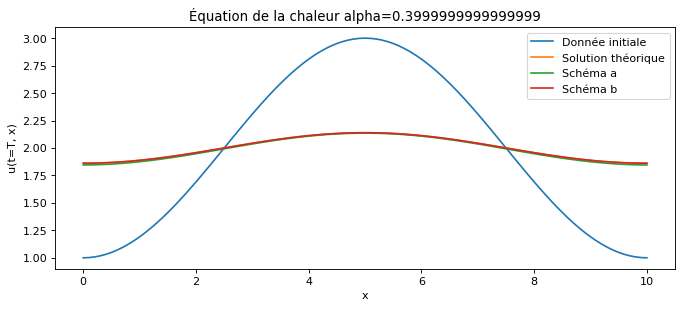

In [43]:
# Tracer les solutions numériques obtenues avec les différents schémas
# Comparer à la solution exacte

#parametres donnes
nu = 1
L = 10
J = 100
dt = 0.004
T = 5

#on calcule alpha, N et dx
N = int(np.round(T/dt))
dx = L/J
alpha = (nu*dt)/(dx**2)

#on calcules les matrices et les solutions respectives
A1 = A_explicite1(alpha, J)
A2 = A_explicite2(alpha, J)

t = np.linspace(0, T, N+1)
x = np.linspace(0, L, J+1)
U0 = u0_1(x)

u1, masse1, energie1 = schema_explicite_chaleur(U0, A1, N, dx)
u2, masse2, energie2 = schema_explicite_chaleur(U0, A2, N, dx)
u_theorique = u_th(T, x)

#on trace les solutions!
plt.figure(figsize=(10, 4), dpi=80)
plt.title(f"Équation de la chaleur alpha={alpha}")
plt.plot(x, U0, label="Donnée initiale")
plt.plot(x, u_theorique, label="Solution théorique")
plt.plot(x, u1, label="Schéma a")
plt.plot(x, u2, label="Schéma b")
plt.xlabel("x")
plt.ylabel("u(t=T, x)")
plt.legend()
plt.show()

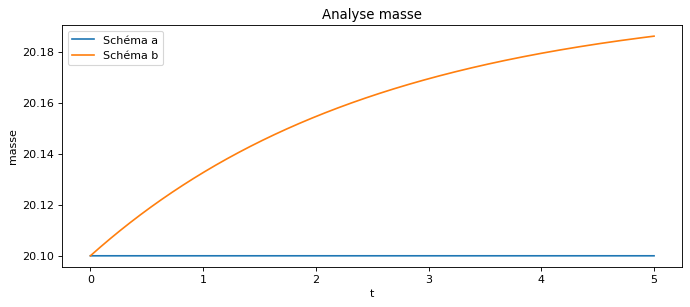

In [44]:
# Tracer la masse des solutions numériques obtenues avec les différents schémas en fonction du temps
plt.figure(figsize=(10, 4), dpi=80)
plt.title("Analyse masse")
plt.plot(t, masse1, label="Schéma a")
plt.plot(t, masse2, label="Schéma b")
plt.xlabel("t")
plt.ylabel("masse")
plt.legend()
plt.show()

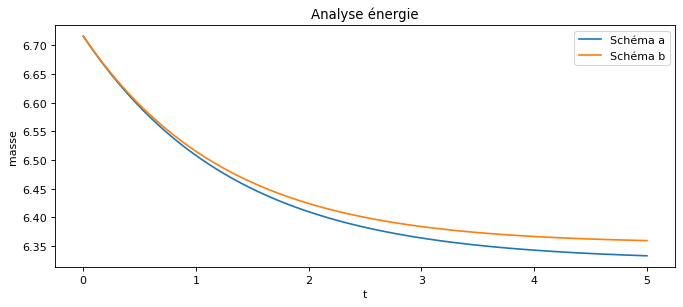

In [45]:
# Tracer l'énergie des solutions numériques obtenues avec les différents schémas en fonction du temps
 # Tracer la masse des solutions numériques obtenues avec les différents schémas en fonction du temps
plt.figure(figsize=(10, 4), dpi=80)
plt.title("Analyse énergie")
plt.plot(t, energie1, label="Schéma a")
plt.plot(t, energie2, label="Schéma b")
plt.xlabel("t")
plt.ylabel("masse")
plt.legend()
plt.show()

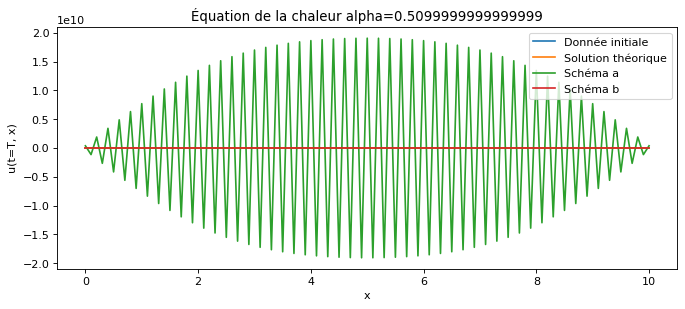

In [48]:
# Tracer les solutions numériques obtenues avec les différents schémas avec les nouveaux paramètres
#parametres donnes
nu = 1
L = 10
J = 100
dt = 0.0051
T = 5.1

#on calcule alpha, N et dx
N = int(np.round(T/dt))
dx = L/J
alpha = (nu*dt)/(dx**2)

#on calcules les matrices et les solutions respectives
A1 = A_explicite1(alpha, J)
A2 = A_explicite2(alpha, J)

t = np.linspace(0, T, N+1)
x = np.linspace(0, L, J+1)
U0 = u0_1(x)

u1, masse1, energie1 = schema_explicite_chaleur(U0, A1, N, dx)
u2, masse2, energie2 = schema_explicite_chaleur(U0, A2, N, dx)
u_theorique = u_th(T, x)

#on trace les solutions!
plt.figure(figsize=(10, 4), dpi=80)
plt.title(f"Équation de la chaleur alpha={alpha}")
plt.plot(x, U0, label="Donnée initiale")
plt.plot(x, u_theorique, label="Solution théorique")
plt.plot(x, u1, label="Schéma a")
plt.plot(x, u2, label="Schéma b")
plt.xlabel("x")
plt.ylabel("u(t=T, x)")
plt.legend()
plt.show()

**Réponse :**

<div class="alert alert-block alert-info">
    On a montré que le schéma a est converge si $\alpha \leq \frac{1}{2}$. $\\$
    Dans le premier exemple, on a $\alpha = 0.4$ et donc on observe qu'on a bien convergence. Mais pour le deuxième exemple avec $\alpha = 0.51$ on observe que le schéma a explose et n'a pas convergé vers la solution théorique. Analogiquement, le schéma b a convergé pour le premier exemple mais pas dans le deuxième. $\\$
    L'idée centrale est que la stabilité est liée à la valeur d'alpha et au dessus d'une valeur limite on observe que les méthodes ne convergent pas.
</div>

### Question 3 : Schéma "différences finies" implicite en temps

>On considère le schéma donné par
>
>$$ \frac{U^{n+1}_j - U^n_j}{\Delta t} - \nu \frac{U^{n+1}_{j-1}-2U^{n+1}_j+U^{n+1}_{j+1}}{(\Delta x)^2} = 0 \qquad{} \forall~n\geq 1,\quad{} \forall~ 0\leq j\leq J+1. \qquad{} (4) $$
>
>Afin d'approcher les conditions aux bords, on utilisera à nouveau les équations (3a) ou (3b) en remplaçant $n$ par $n+1$.

$1$. Donner les matrices $A^{impl}_1$ et $A^{impl}_2$ de taille $(J+1)\times(J+1)$ permettant d'écrire ce schéma sous la forme $A^{impl}_1 U^{n+1}=U^n$ pour la convention (3a) et $A^{impl}_2 U^{n+1}= U^n$ pour la convention (3b). Montrer que ces deux matrices sont inversibles. *Faire à nouveau apparaitre le nombre sans dimension $\alpha = \frac{\nu \Delta t}{\Delta x^2}$.*

<div class="alert alert-block alert-info">
    
</div>

$2$. **Propriétés numériques :**

>**Remarque :** On peut montrer comme dans la partie précédente que le schéma est consistant (remplacer les $n$ par des $n+1$ dans la définition de l'erreur de troncature) avec les mêmes ordres. 

**Stabilité en norme $\ell_{\Delta x}^2$ :** Montrer que le schéma (4) muni des conditions de bord (3a) est inconditionnellement stable en norme $\ell_{\Delta x}^2$. 

>**Remarque :** On peut ensuite montrer comme dans la partie précédente que le schéma est convergent.

<div class="alert alert-block alert-info">
    
</div>

$3$. **Propriétés Physiques :**

$a$. **Principe du maximum discret :** Soient $i\in{1,2}$ et $X,Y\in\mathbb{R}^{J+1}$ tels que $A^{impl}_i X = Y$. Montrer que si $Y\geq 0$ (au sens où $Y_j\geq 0$ pour tout $j$), alors $X\geq 0$. En déduire que, sans condition sur $\alpha$, le schéma vérifie

$$ \forall~n\geq 0,\ \forall~0\leq j\leq J, \quad{} \min_i U^n_i \leq U^{n+1}_j \leq \max_i U^n_i. $$

*Indication : on pourra montrer que $U^{n+1}-\left(\min_{i} U^n_i\right) e \geq 0$ et $\left(\max_{i}U^n_i\right) e -U^{n+1} \geq 0$, où $e\in\mathbb{R}^{J+1}$ est défini comme à la question 1.c).*

$b$. **Conservation de la masse :** Étudier, en fonction du choix entre (3a) et (3b), si le schéma préserve ou pas la masse, c'est à dire si

$$ \forall n\geq 0, \quad{} \sum_{j=0}^{J} U^{n+1}_j \Delta x = \sum_{j=0}^{J} U^{n}_j\Delta x. $$

*On pourra à nouveau considérer le vecteur $e\in \mathbb{R}^{J+1}$ et remarquer que la masse s'écrit $e^T\, U^n \Delta x$.*

<div class="alert alert-block alert-info">
    
</div>

$4$.  **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  **Implémentation :**

$a$. Implémenter les schémas (4-3a) et (4-3b). 

**Comme au point précédent, on définira les schémas numériques à partir des matrices $A_{impl}$ calculées au 1), que l'on implémentera en format creux. On utilisera pour cela la fonction *sparse.diags* de scipy. Pour la résolution d'un problème linéaire *AU=b*, on utilsera *splu*, la décomposition LU adaptée au format creux, et sa résolution *A.solve()*. *Il est bien entendu recommandé de lire la documentation de ces fonctions.***

$b$. Pour chaque schéma, utiliser $\Delta t= 0.1$ et afficher la solution obtenue pour $T=5$, ainsi que la donnée initiale et la solution théorique au temps $T$. 

$c$. Sur un autre graphique, afficher la masse $\sum_{j=0}^{J} U^{n}_j\Delta x $ en fonction de $n$ pour les deux schémas. Sur un autre graphique, afficher l'énergie $\left\Vert U^n \right\Vert_{\ell_{\Delta x}^2}$ en fonction de $n$  pour les deux schémas. 

$d$. Commenter les différents résultats obtenus et discuter des avantages et des inconvénients des schémas explicites et implicites pour ce problème.

In [ ]:
def A_implicite1(alpha,J):
    """
    Calcule la matrice A_{impl} correspondant au schéma (4-3a) en format sparse
    ----------   
    parametres:
    alpha : valeur de alpha = nu*dt/dx**2
    J     : nombre de points de discrétisation (A_{impl} est de taille J+1xJ+1)
    
    valeurs de retour:
    A     : matrice A_{impl} correspondant au schéma (4-3a) en format sparse
    """
    
    return 

def A_implicite2(alpha,J):    
    """
    Calcule la matrice A_{impl} correspondant au schéma (4-3b) en format sparse
    ----------   
    parametres:
    alpha : valeur de alpha = nu*dt/dx**2
    J     : nombre de points de discrétisation (A_{impl} est de taille J+1xJ+1)
    
    valeurs de retour:
    A     : matrice A_{impl} correspondant au schéma (4-3b) en format sparse
    """
    
    return 

In [ ]:
# Cellule de test pour vérifier les valeurs de ces matrices


In [ ]:
def schema_implicite_chaleur(U0, A, N, dx):
    """
    Calcule itérativement les U_i^n obtenus avec le schéma (4-3a) ou (4-3b) 
    ----------   
    parametres:
    U_0 : vecteur contenant les valeurs de U au temps 0
    A   : matrice A_{impl} correspondant au schéma (4-3a) ou (4-3b)
    N   : nombre de pas de temps (N * dt = T)
    dx  : pas d'espace
    
    valeurs de retour:
    U       : vecteur des U_i^n au temps final t^n = T = N * dt 
    masse   : vecteur contenant la masse (sum U_j^n dx) à tous les temps n
    energie : vecteur contenant la masse (||U^n||_l2dx) à tous les temps n
    """
       
    return 

In [ ]:
# Tracer les solutions numériques obtenues avec les différents schémas
# Comparer à la solution exacte


In [ ]:
# Tracer la masse des solutions numériques obtenues avec les différents schémas en fonction du temps
 

In [ ]:
# Tracer l'énergie des solutions numériques obtenues avec les différents schémas en fonction du temps
 

**Réponse :**

## Exercice 2  : Étude d'une onde progressive
  
> On se donne toujours $\nu>0$ un coefficient de diffusion, et $u^0\in C^0(\mathbb{R})$ une donnée initiale, et on considère désormais une équation de réaction-diffusion de la forme :
>
> $$ 
  \left\{
  \begin{aligned}
  &\displaystyle\frac{\partial u}{\partial t}(t,x)-\nu\frac{\partial^2 u}{\partial x^2}(t,x) = g(u(t,x)), \quad &\forall (t,x) \in\mathbb{R}_+^*\times\mathbb{R}, \\  
  &u(x,0) = u^0(x), \quad &\forall x\in\mathbb{R},
  \end{aligned}
  \right. \qquad{} (5)
$$
>
>où $g:\mathbb{R}\to\mathbb{R}$ est donnée par
>
>$$ g(u) = ku^2(1-u). \qquad{} (6) $$
>
>Cette équation, parfois appelée équation de Nagumo, permet de décrire des phénomènes de propagation. En effet, pour certaines conditions initiales, on peut montrer que la solution se rapproche d'une *onde progressive*, c'est à dire d'une solution de la forme
>
> $$ u(t,x) = \beta(x-ct) \qquad{} (7a) $$
>
>où
>
>$$ c= \sqrt{\frac{k\nu}{2}},\qquad{} \beta(\xi) = \frac{e^{-c(\xi-\xi_0)}}{1+e^{-c(\xi-\xi_0)}}, \qquad{} (7b)$$
>
>et $\xi_0\in\mathbb{R}$ dépend de la donnée initiale.
>
>
>On va essayer d'observer numériquement ce phénomène, à l'aide de différents schémas. Pour ce faire, on se place en domaine borné, et on considère donc à nouveau $\Omega=]0,L[$ (dans la pratique on prendra $L\gg 1$), et l'équation
>
>$$  \left\{
  \begin{aligned}
  &\displaystyle\frac{\partial u}{\partial t}(t,x)-\nu\frac{\partial^2 u}{\partial x^2}(t,x) = g(u(t,x)), \quad &\forall~(t,x) \in\mathbb{R}_+^*\times\Omega,  \\ 
  &\frac{\partial u}{\partial x}(t,0) = 0 = \frac{\partial u}{\partial x}(t,L )\quad &\forall~t\in\mathbb{R}_+^*, \\ 
  &u(x,0) = u^0(x), \quad &\forall x\in\Omega,
  \end{aligned}
  \right. \qquad{} (8)
$$
>
>toujours avec $g$ donnée par (6). Pour les simulations, on prendra dans cet exercice
>
>$$ \nu=0.1,\quad{} L=100,\quad{} k=10,\quad{} \text{et}\quad{} u^0(x) =
\left\{
\begin{aligned}
& 1,\quad & x\leq \frac{L}{10} \\
& 0,\quad & x >\frac{L}{10}.
\end{aligned}
\right.$$
>
>On utilisera les mêmes types de discrétisations spatiales et temporelles que dans l'exercice précédent, avec $J=1000$ ($\Delta x = \frac{L}{J}$), et différentes valeurs de $T$ et de $\Delta t$ données plus loin.

### Question 1 : Solution théorique

Vérifiez que l'onde progressive $u$ définie en (7) est bien solution de l'équation de Nagumo (6) sur $\mathbb{R}$, avec $u^0(x) = \beta(x)$.

<div class="alert alert-block alert-info">
    
</div>

### Question 2 : Schéma totalement explicite

>On considère le schéma donné par
>
>$$ \frac{U^{n+1}_j - U^n_j}{\Delta t} - \nu \frac{U^n_{j-1}-2U^n_j+U^n_{j+1}}{(\Delta x)^2} = g(U^n_j) \qquad{} \forall~n\geq 1,\ \forall~ 0\leq j\leq J, $$
>
>avec les conventions (3b), qu'on peut réécrire
>
>$$ U^{n+1} = A^{expl}_2 U^n + \Delta t\, g(U^n), \qquad{} (9) $$
>
>avec les notations de l'Exercice 1, $g(U^n)$ désignant le vecteur $\left(g(U^n_j)\right)_{0\leq j\leq J}$.

$a$.  **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Implémenter ce schéma et afficher les solutions obtenues à $T=0$, $T=20$, $T=40$ et $T=60$, avec $\Delta t = 0.025$ (sur un même graphique, avec différentes couleurs). 

$b$.  **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Répeter ces expériences avec $\Delta t =0.045$. Commenter les résultats obtenus (calculer dans les deux cas $\alpha = \frac{\nu\Delta t}{\Delta x^2}$).

In [ ]:
def g(x, k):
    # definition de la fonction g
    # x : position
    # k : paramètre d'amplitude du terme source
    return k * x**2 * (1-x)

def u0_2(x, L):
    # definition de la condition initiale
    # x  : position
    # L : taille du domaine
    return 1. * (x <= L/10)

In [ ]:
def schema_explicite_reaction_diffusion(U0, A, N, g, k, dt):  
    """
    Calcule itérativement les U_i^n obtenus avec le schéma (9) 
    ----------   
    parametres:
    U_0 : vecteur contenant les valeurs de U au temps 0
    A   : matrice A_{expl} correspondant au schéma (9)
    N   : nombre de pas de temps (N * dt = T)
    g   : fonction du terme source
    k   : parametre d'amplitude du terme source 
    dt  : pas de temps
    
    valeurs de retour:
    U   : vecteur des U_i^n au temps final t^n = T = N * dt 
    """
    
    return 

In [ ]:
# Tracer la solution numérique obtenue aux différents temps
# Comparer à la solution exacte


In [ ]:
# Tracer la solution numérique obtenue aux différents temps avec le nouveau pas de temps
# Comparer à la solution exacte


**Réponse :**

### Question 3 : Schéma semi-implicite :

>On considère le schéma donné par
>
>$$ \frac{U^{n+1}_j - U^n_j}{\Delta t} - \nu \frac{U^{n+1}_{j-1}-2U^{n+1}_j+U^{n+1}_{j+1}}{(\Delta x)^2} = g(U^n_j) \qquad{} \forall~n\geq 1,\ \forall~ 0\leq j\leq J+1, $$
>
>avec les conventions (3b), qu'on peut réécrire
>
>$$ A^{impl}_2 U^{n+1} = U^n + \Delta t\, g(U^n). \qquad{} (10) $$

$a$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Implémenter ce schéma et afficher les solutions obtenues à $T=0$, $T=20$, $T=40$ et $T=60$, avec $\Delta t = 0.045$ (sur un même graphique, avec différentes couleurs).

$b$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Répeter ces expériences avec $\Delta t = 0.4$. Commenter.

In [ ]:
def schema_semi_implicite_reaction_diffusion(U0, A, N, g, k, dt):   
    """
    Calcule itérativement les U_i^n obtenus avec le schéma (10) 
    ----------   
    parametres:
    U_0 : vecteur contenant les valeurs de U au temps 0
    A   : matrice A_{impl} correspondant au schéma (10)
    N   : nombre de pas de temps (N * dt = T)
    g   : fonction du terme source
    k   : parametre d'amplitude du terme source 
    dt  : pas de temps
    
    valeurs de retour:
    U   : vecteur des U_i^n au temps final t^n = T = N * dt 
    """
    
    return 

In [ ]:
# Tracer la solution numérique obtenue aux différents temps
# Comparer à la solution exacte


In [ ]:
# Tracer la solution numérique obtenue aux différents temps avec le nouveau pas de temps
# Comparer à la solution exacte


**Réponse :**

### Question 4 : Schéma totalement implicite :

>On considère le schéma donné par
>
>$$ \frac{U^{n+1}_j - U^n_j}{\Delta t} - \nu \frac{U^{n+1}_{j-1}-2U^{n+1}_j+U^{n+1}_{j+1}}{(\Delta x)^2} = g(U^{n+1}_j) \qquad{} \forall~n\geq 1,\ \forall~0\leq j\leq J, $$
>
>avec les conventions (3b), qu'on peut réécrire
>
>$$ A^{impl}_2 U^{n+1} = U^n + \Delta t\, g(U^{n+1}). \qquad{}(11) $$
>
>Étant donné $U^n$, on doit donc résoudre un système non-linéaire pour trouver $U^{n+1}$. On peut reformuler ce problème en disant qu'on cherche un zéro de la fonction $F^n : \mathbb{R}^{J+1}\to\mathbb{R}^{J+1}$ définie par
>
>$$ F^n (V) = A^{impl}_2 V - \Delta t\, g(V) - U^n. $$
>
>On rappelle qu'on peut utiliser la méthode de Newton pour trouver un zéro approché :
>
>$$ \left\{\begin{aligned}
&V_0 = U^n \\
&V_{k+1} = V_k - \left(DF^n(V_k)\right)^{-1} F^n (V_k).
\end{aligned}\right. $$
>
>Une fois que la méthode de Newton a convergé, on peut prendre pour $U^{n+1}$ le dernier itéré $V_k$ obtenu.

$a$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Implémenter ce schéma et afficher les solutions obtenues à $T=0$, $T=20$, $T=40$ et $T=60$, avec $\Delta t = 0.4$ (sur un même graphique, avec différentes couleurs).

**On exploitera à nouveau le stockage creux, et notamment la fonction *spsolve* pour la résolution d'un problème linéaire creux (dans l'algorithme de Newton).**

$b$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>**  Répéter ces éxpériences avec $\Delta t = 0.045$. Commenter.

In [ ]:
def dg(x,k):
    # dérivée du terme source
    return k*x*(2-3*x)

def schema_implicite_reaction_diffusion(U, A, N, g, dg, k, dt, itmax=20, tol=1.e-10):
    """
    Calcule itérativement les U_i^n obtenus avec le schéma (11) 
    ----------   
    parametres:
    U_0 : vecteur contenant les valeurs de U au temps 0
    A   : matrice A_{impl} correspondant au schéma (11)
    N   : nombre de pas de temps (N * dt = T)
    g   : fonction du terme source
    dg  : dérivée de la fonction du terme source
    k   : parametre d'amplitude du terme source 
    dt  : pas de temps
    
    valeurs de retour:
    U   : vecteur des U_i^n au temps final t^n = T = N * dt 
    """
    
    return 

In [ ]:
# Tracer la solution numérique obtenue aux différents temps
# Comparer à la solution exacte


In [ ]:
# Tracer la solution numérique obtenue aux différents temps avec le nouveau pas de temps
# Comparer à la solution exacte


**Réponse :**